# H02C8b Information Retrieval and Search Engines: RAG Project

Welcome to the notebook companion for the IRSE project. You will find all starter code here. You are encouraged to use this code, as it has been confirmed to work for the RAG pipeline described in the assignment handout. However, you are certainly welcome to make any changes you see fit, provided that your code is written in Python and runs without issue.

**IMPORTANT**: Do not submit a notebook as your final solution. It will not be graded. Refer to assignment handout for more information about the submission format.

**IMPORTANT**: Be mindful of your runtime usage, if working in Colab. At the beginning of every session, navigate to the top menu bar in Colab and select **Runtime > Change runtime type > CPU (Python 3)**. This will ensure that your session runs on CPU and that you do not waste any GPU allocation for the day. GPUs are provided by Google on a limited daily basis, and access is given every 24 hours. It is best that you complete the TF-IDF/search component before loading models and running inference on the GPU runtime.


If you have any questions, feel free to email [Thomas](mailto:thomas.bauwens@kuleuven.be) or [Kushal](mailto:kushaljayesh.tatariya@kuleuven.be).

## RAG for recipe recommendation:

We will begin by installing the huggingface `datasets` library for easily loading our data.

In [1]:
# ! pip -q install datasets
# !wget https://people.cs.kuleuven.be/~thomas.bauwens/irse_documents_2025_recipes.parquet
# !wget https://people.cs.kuleuven.be/~thomas.bauwens/irse_queries_2025_recipes.json


In [1]:
import json
import nltk
import numpy as np
import pandas as pd
import json
import string
import datasets
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import math
import numpy as np
from nltk.corpus import stopwords

import string
from nltk.tokenize import word_tokenize
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

tqdm.pandas()  # Show progress bar if using pandas

import nltk
from utils import *
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

# from google.colab import userdata
# userdata.get("HF_TOKEN")

/home/yan/yan_files/2_semester/information_retrieval/project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/yan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/yan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yan/nltk_data...
[nltk_data]   Package punkt_tab is al

True

In [2]:
dataset = datasets.load_dataset(
    "parquet", data_files="./irse_documents_2025_recipes.parquet"
)["train"]
queries_data = json.load(open("./irse_queries_2025_recipes.json", "r"))

df = dataset.to_pandas()

# Now you can apply the function to concatenate columns
recipies = df.apply(
    lambda row: f"{row['name']} {row['description']} {row['ingredients']} {row['steps']}",
    axis=1,
)  # [:10000]
recipe_ids = dataset["official_id"]  # [:10000]
print("Number of documents:", len(recipies))

queries = pd.DataFrame(columns=["q", "r", "a"])
for query_item in queries_data["queries"]:
    query_text = query_item["q"]
    relevance_pairs = query_item["r"]
    answer = query_item["a"]
    queries = pd.concat(
        [
            queries,
            pd.DataFrame({"q": [query_text], "r": [relevance_pairs], "a": [answer]}),
        ],
        ignore_index=True,
    )

print("Number of queries:", len(queries))

Number of documents: 231637
Number of queries: 47


In [35]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_vocabulary(doc):
    doc = doc.translate(str.maketrans("", "", string.punctuation)).lower()

    words = word_tokenize(doc)

    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and not word.isalpha()
    ]

    return " ".join(words)


preprocessed_recipes = [preprocess_vocabulary(doc) for doc in tqdm(recipies)]


  0%|          | 0/231637 [00:00<?, ?it/s]

100%|██████████| 231637/231637 [01:17<00:00, 2970.64it/s]


#### Preprocessor

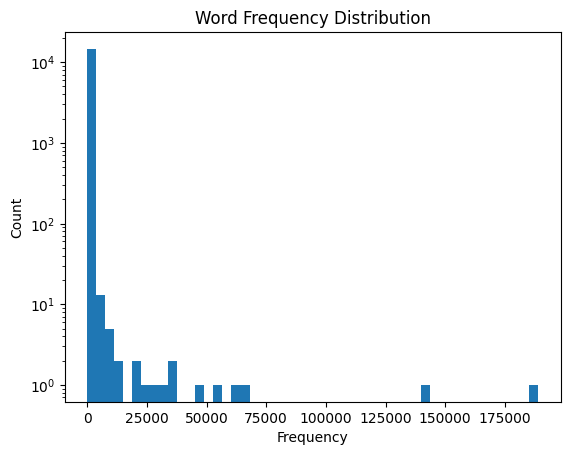

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

all_words = ' '.join(preprocessed_recipes).split()
word_freq = Counter(all_words)
freqs = list(word_freq.values())
plt.hist(freqs, bins=50, log=True)
plt.title("Word Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

vectorizer = TfidfVectorizer(
    max_features=5000,  # Top 5000 most frequent terms
    min_df=10,  # Ignore terms that appear in fewer than 5 documents
    max_df=0.8,  # Ignore terms that appear in more than 80% of docs
    ngram_range=(1, 2),
)

X = vectorizer.fit_transform(preprocessed_recipes)


In [37]:
vocab = vectorizer.get_feature_names_out()
print(vocab)  # Print first 50 to preview


['00' '000' '01' ... 'zwt8' 'zwt8 10' 'zwt9']


#### TF-IDF

In [18]:
from utils import *

In [19]:
def retrieve_documents(query_text, recipies, recipe_ids, k=None, threshold=None):
    if len(recipies) != len(recipe_ids):
        raise ValueError("Recipes and recipe_ids must have the same length")
    if k is None and threshold is None:
        raise ValueError("Either k or threshold must be specified")
    if vectorizer is None or X is None:
        raise ValueError("Vectorizer and document matrix X must be provided")

    query = preprocess_vocabulary(query_text)
    query_vector = vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_vector, X).flatten()

    results = [
        (recipies[i], recipe_ids[i], cosine_similarities[i])
        for i in range(len(recipies))
    ]
    results.sort(key=lambda x: x[2], reverse=True)

    if threshold is not None:
        results = [r for r in results if r[2] >= threshold]

    if k is not None:
        results = results[:k]

    return results


In [20]:
def evaluate_ir_system(queries, recipies, recipe_ids, k=None, threshold=None):
    metrics_per_query = []
    all_relevant_doc_ids = []
    all_retrieved_doc_ids = []

    for _, row in queries.iterrows():
        query_text = row["q"]
        relevant_doc_ids = [doc[0] for doc in row["r"]]

        results = retrieve_documents(query_text, recipies, recipe_ids, k, threshold)
        retrieved_doc_ids = [result[1] for result in results]

        query_metrics = calculate_precision_recall_f1_optimized(
            relevant_doc_ids, retrieved_doc_ids
        )
        metrics_per_query.append(query_metrics)

        all_relevant_doc_ids.append(relevant_doc_ids)
        all_retrieved_doc_ids.append(retrieved_doc_ids)

    macro_metrics = calculate_macro_averages(metrics_per_query)
    micro_metrics = calculate_micro_averages_optimized(
        all_relevant_doc_ids, all_retrieved_doc_ids
    )

    all_metrics = {**macro_metrics, **micro_metrics}
    return all_metrics


In [28]:
best_K=29
best_threshold=0.24

In [29]:
# evaluate_ir_system(queries.iloc[[34]], recipies, recipe_ids, k=best_K, threshold=best_threshold)

In [30]:
metrics = evaluate_ir_system(queries, recipies, recipe_ids, k=best_K, threshold=best_threshold)

print("\n===== IR System Evaluation Results =====")
print(f"Macro-average Precision: {metrics['macro_precision']:.4f}")
print(f"Macro-average Recall: {metrics['macro_recall']:.4f}")
print(f"Macro-average F1: {metrics['macro_f1']:.4f}")
print(f"Micro-average Precision: {metrics['micro_precision']:.4f}")
print(f"Micro-average Recall: {metrics['micro_recall']:.4f}")
print(f"Micro-average F1: {metrics['micro_f1']:.4f}")
print("========================================")


===== IR System Evaluation Results =====
Macro-average Precision: 0.0630
Macro-average Recall: 0.2471
Macro-average F1: 0.0626
Micro-average Precision: 0.0833
Micro-average Recall: 0.1332
Micro-average F1: 0.1025


For a given query and set of relevant documents, you are also required to create a prompt that instructs a model to complete a certain task (e.g. recipe recommendation). You should experiment with formatting the prompt, as language models have been shown to be sensitive to the exact verbiage of instructions.

In [ ]:

results = create_parameter_heatmap(queries, recipies, recipe_ids)

Evaluating combinations:  58%|█████▊    | 64/110 [33:11<23:43, 30.95s/it]

In [22]:
prompt = """

# Recipe Assistant

## Context
You are a helpful recipe assistant with access to a database of recipes. The system has already retrieved the most relevant recipes to the user's query using TF-IDF similarity. Your goal is to provide helpful, accurate responses about recipes, cooking techniques, ingredient substitutions, and culinary advice based on the retrieved recipes.

## Retrieved Recipes
The following recipes have been retrieved as most relevant to the user's query:

{retrieved_recipes}

## Instructions
1. **Answer directly from the retrieved recipes when possible.** Use the information from the provided recipes to answer questions about ingredients, cooking methods, nutritional information, and preparation steps.

2. **For ingredient questions:**
   - Provide accurate amounts and measurements from the recipes
   - Suggest possible substitutions based on common culinary knowledge
   - Explain the purpose of key ingredients in the dish

3. **For cooking technique questions:**
   - Explain preparation methods mentioned in the recipes
   - Clarify cooking times and temperatures
   - Describe expected results and how to tell when food is properly cooked

4. **For modification requests:**
   - Suggest appropriate adjustments for dietary restrictions (vegan, gluten-free, etc.)
   - Explain how to scale recipes up or down
   - Offer ideas for flavor variations while maintaining the core identity of the dish

5. **For general questions:**
   - Provide brief culinary background/history when relevant
   - Explain unfamiliar cooking terms
   - Suggest pairings, serving suggestions, and storage recommendations

## Response Format
- Start with a direct answer to the user's question
- Keep your responses concise but comprehensive
- For multi-step instructions or complex concepts, organize information in a clear, logical structure
- If the retrieved recipes don't contain sufficient information to answer the query, acknowledge the limitations and provide general culinary knowledge that might help
- When suggesting modifications not explicitly in the retrieved recipes, clearly indicate these are your recommendations based on culinary principles

## Limitations
- Don't make claims about specific nutritional values unless they're mentioned in the retrieved recipes
- If asked about topics completely unrelated to cooking or the recipes provided, politely redirect the conversation back to recipe-related topics
- Don't invent or fabricate details about recipes that aren't in the retrieved data

## User Query
{user_query}
"""

In [23]:
irrelevant_context = """
Richard Gary Brautigan (January 30, 1935 – c. September 16, 1984)
was an American novelist, poet, and short story writer. A prolific writer,
he wrote throughout his life and published ten novels, two collections of
short stories, and four books of poetry. Brautigan's work has been published
both in the United States and internationally throughout Europe, Japan,
and China. He is best known for his novels Trout Fishing in America (1967),
In Watermelon Sugar (1968), and The Abortion: An Historical Romance 1966 (1971).
"""

**IMPORTANT**: only run the following code when you have implemented a working retrieval system. When you are ready to work with language models, navigate to the menu bar in Colab and select **Runtime > Change runtime type > T4 GPU**. If you find yourself working on not GPU-intenstive tasks in this notebook, change your runtime back to CPU to preserve access.


In [24]:
! pip -q install git+https://github.com/huggingface/transformers
! pip -q install datasets bitsandbytes accelerate xformers einops

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires scipy, which is not installed.
sentence-transformers 3.4.1 requires torch>=1.11.0, which is not installed.
^C
ERROR: Operation cancelled by user


In [ ]:
import torch
import transformers
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import userdata


In [ ]:
from huggingface_hub import login

# Replace "YOUR_HF_TOKEN" with your actual Hugging Face token
login(token=userdata.get("HF_TOKEN"))

The code below will load a Mistral 7B instruct model and quantize it via `bitesandbytes`. Doing so will ensure that the model will not take up too much memory and make inference more efficient. Note that the call to `AutoModelForCausalLM.from_pretrained()` will take a while, as the model's weights must be downloaded from the huggingface hub. Also note that you are not restricted to using Mistral, and are welcome to experiment with other models (though you will have more luck with chat and instruction-tuned variants).

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, quantization_config=bnb_config, device_map="auto"
)

A tokenizer is required in order to convert strings into integer sequences that can be passed as input to the model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
retrieved_recipes = "1. Chocolate Chip Cookies...\n2. Brownie Bites..."
user_query = "Can I use coconut oil instead of butter in cookies?"

# Fill in the template
input_string_with_context = prompt.format(
    retrieved_recipes=retrieved_recipes, user_query=user_query
)

input_string_without_context = prompt.format(
    retrieved_recipes=irrelevant_context, user_query=user_query
)

In [ ]:
encoded_prompt = tokenizer(
    input_string_with_context, return_tensors="pt", add_special_tokens=False
)
encoded_prompt = encoded_prompt.to("cuda")
generated_ids = model.generate(**encoded_prompt, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

In [ ]:
encoded_prompt = tokenizer(
    input_string_without_context, return_tensors="pt", add_special_tokens=False
)
encoded_prompt = encoded_prompt.to("cuda")
generated_ids = model.generate(**encoded_prompt, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])